# Project 3: Economic Model
### Andrey Aksyutkin and Miguel Fernandez Darder

In [14]:
import numpy as np
import math
from math import log
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt

This initial implementation of the AR(1) + noisy observation model will not be used later in the code but we find it explanatory to leave it here for easier understanding of the initialization

In [15]:
#Initial AR(1) model to which we want to estimate using the different filters:
# Set random seed for reproducibility
np.random.seed(1234)  
T = 100  # length of time series
phi_true = 0.9                 # true AR(1) coefficient
alpha_true = 1.5               # true measurement coefficient
sigma2_true = 0.1              # true process noise variance
tau2_true = 0.2                # true measurement noise variance

# Initialize arrays
x_true = np.zeros(T)
y_obs  = np.zeros(T)

# Initial state x_0 
x_true[0] = np.random.normal(0, np.sqrt(sigma2_true/(1-phi_true**2)))
y_obs[0]  = alpha_true * x_true[0] + np.random.normal(0, np.sqrt(tau2_true))

# Simulate forward
for t in range(1, T):
    x_true[t] = phi_true * x_true[t-1] + np.random.normal(0, np.sqrt(sigma2_true))
    y_obs[t]  = alpha_true * x_true[t] + np.random.normal(0, np.sqrt(tau2_true))

# Display first few data points
print("First 5 true states:", x_true[:5])
print("First 5 observations:", y_obs[:5])

First 5 true states: [0.34201501 0.76087524 0.45691755 0.68305152 0.61970999]
First 5 observations: [-0.019598    1.00149068  1.08212765  0.73991531 -0.07339421]


### Particle Filter

In [16]:
def particle_filter(y_obs, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2, N=1000):
   """
   Particle Filter for estimating state and parameters of an AR(1) model.
   """
   T = len(y_obs)
   
   # Initialize particles from prior
   particles = np.random.normal(0, np.sqrt(sigma2/(1-phi**2)), size=N)
   weights = np.ones(N) / N  # start with equal weights
   
   state_estimates = np.zeros(T)
   
   # Update weights with first observation
   diff0 = y_obs[0] - alpha * particles
   likelihoods = np.exp(-0.5 * (diff0**2) / tau2) / np.sqrt(2*np.pi*tau2)
   weights *= likelihoods
   weights /= np.sum(weights)  # normalize weights
   state_estimates[0] = np.sum(weights * particles)
   
   # Resample particles
   indices = np.random.choice(np.arange(N), size=N, p=weights)
   particles = particles[indices]
   weights.fill(1.0/N)  # reset weights
   
   # Iterate through time steps 1 to T-1
   for t in range(1, T):
       # Prediction step
       particles = phi * particles + np.random.normal(0, np.sqrt(sigma2), size=N)
       
       # Update step
       diff = y_obs[t] - alpha * particles
       likelihoods = np.exp(-0.5 * (diff**2) / tau2) / np.sqrt(2*np.pi*tau2)
       weights *= likelihoods
       weights /= np.sum(weights)  # normalize
       
       # State estimate
       state_estimates[t] = np.sum(weights * particles)
       
       # Resample
       indices = np.random.choice(np.arange(N), size=N, p=weights)
       particles = particles[indices]
       weights.fill(1.0/N)
   
   # Calculate parameter estimates
   # Estimate phi using regression
   X = state_estimates[:-1].reshape(-1, 1)
   y = state_estimates[1:]
   phi_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate alpha
   X = state_estimates.reshape(-1, 1)
   y = y_obs
   alpha_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate noise variances
   pred_errors = state_estimates[1:] - phi_est * state_estimates[:-1]
   sigma2_est = np.mean(pred_errors**2)
   
   meas_errors = y_obs - alpha_est * state_estimates
   tau2_est = np.mean(meas_errors**2)
   
   params = {
       'phi': phi_est,
       'alpha': alpha_est,
       'sigma2': sigma2_est,
       'tau2': tau2_est
   }
   
   return state_estimates, params


### Kalman Filter

In [17]:
def kalman_filter(y_obs, phi=0.9, alpha=1.5, sigma2=0.1, tau2=0.2):
   """Kalman filter for estimating state and parameters of an AR(1) model."""
   T = len(y_obs)
   x_est = np.zeros(T)
   P_est = np.zeros(T)
   
   # Initialize prior
   x_est[0] = 0.0
   P_est[0] = sigma2/(1-phi**2)  # steady-state variance
   
   # Initial update
   K0 = P_est[0] * alpha / (alpha**2 * P_est[0] + tau2)
   x_est[0] = x_est[0] + K0 * (y_obs[0] - alpha * x_est[0])
   P_est[0] = (1 - K0 * alpha) * P_est[0]
   
   # Iterate for t=1...T-1
   for t in range(1, T):
       # Prediction step
       x_pred = phi * x_est[t-1]
       P_pred = phi**2 * P_est[t-1] + sigma2
       
       # Update step
       Kt = P_pred * alpha / (alpha**2 * P_pred + tau2)
       x_est[t] = x_pred + Kt * (y_obs[t] - alpha * x_pred)
       P_est[t] = (1 - Kt * alpha) * P_pred
   
   # Estimate parameters
   # Estimate phi using regression
   X = x_est[:-1].reshape(-1, 1)
   y = x_est[1:]
   phi_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate alpha
   X = x_est.reshape(-1, 1)
   y = y_obs
   alpha_est = np.linalg.lstsq(X, y, rcond=None)[0][0]
   
   # Estimate noise variances
   pred_errors = x_est[1:] - phi_est * x_est[:-1]
   sigma2_est = np.mean(pred_errors**2)
   
   meas_errors = y_obs - alpha_est * x_est
   tau2_est = np.mean(meas_errors**2)
   
   params = {
       'phi': phi_est,
       'alpha': alpha_est,
       'sigma2': sigma2_est,
       'tau2': tau2_est
   }
   
   return x_est, params

### MLE

In [18]:
def neg_log_likelihood(params, observations):
   """Negative log-likelihood function for AR(1) process"""
   phi, alpha, log_sigma2, log_tau2 = params
   sigma2 = np.exp(log_sigma2)
   tau2 = np.exp(log_tau2)
   T = len(observations)
   
   # Initialize
   x_mean = 0.0
   P_var = sigma2/(1-phi**2) if phi**2 < 1 else sigma2*100
   logL = 0.0
   
   for t in range(T):
       # Compute innovation and its variance
       S = alpha**2 * P_var + tau2
       nu = observations[t] - alpha * x_mean
       
       # Update log-likelihood
       logL += -0.5*(np.log(2*np.pi*S) + (nu**2)/S)
       
       # Kalman update
       K = (P_var * alpha) / S
       x_mean = x_mean + K * nu
       P_var = (1 - K*alpha) * P_var
       
       # Predict next
       if t < T-1:
           x_mean = phi * x_mean
           P_var = phi**2 * P_var + sigma2
   
   return -logL  # Return negative for minimization
def mle_estimation(y_obs):
    """
    Maximum Likelihood Estimation for AR(1) parameters with state estimation
    """
    from scipy.optimize import minimize
    
    # Initial guess [phi, alpha, log(sigma2), log(tau2)]
    initial_guess = [0.5, 1.0, np.log(0.1), np.log(0.2)]
    
    # Minimize negative log-likelihood
    result = minimize(neg_log_likelihood, initial_guess, args=(y_obs,))
    
    # Extract parameters
    phi_est, alpha_est, log_sigma2_est, log_tau2_est = result.x
    sigma2_est = np.exp(log_sigma2_est)
    tau2_est = np.exp(log_tau2_est)
    
    # With optimal parameters, run Kalman filter to get state estimates
    x_est, _ = kalman_filter(y_obs, phi=phi_est, alpha=alpha_est, 
                            sigma2=sigma2_est, tau2=tau2_est)
    
    params = {
        'phi': phi_est,
        'alpha': alpha_est,
        'sigma2': sigma2_est,
        'tau2': tau2_est
    }
    
    return x_est, params

### Hypothesis testing

In [19]:
def parameter_hypothesis_tests(true_params, estimated_params, method_name):
   """Run hypothesis tests on parameter estimates"""
   print(f"\n{method_name} Parameter Estimates:")
   for param, true_val in true_params.items():
       est_val = estimated_params[param]
       error = est_val - true_val
       pct_error = 100 * abs(error) / true_val
       print(f"{param}: True={true_val:.4f}, Est={est_val:.4f}, Error={error:.4f}, %Error={pct_error:.2f}%")

### Function for testing gaussian and non-gaussian noise implementations of the AR(1) model

In [20]:
def test_non_gaussian_noise(noise_type='t', seed=42):
   """Test filter performance with non-Gaussian noise"""
   import scipy.stats as stats
   
   # Parameters
   T = 1000
   phi = 0.9
   alpha = 1.5
   sigma2 = 0.1
   tau2 = 0.2
   
   # Set random seed
   np.random.seed(seed)
   
   # Initialize arrays
   x_true = np.zeros(T)
   y_obs = np.zeros(T)
   
   # Generate process noise
   if noise_type == 'gaussian':
       proc_noise = np.random.normal(0, np.sqrt(sigma2), T)
       meas_noise = np.random.normal(0, np.sqrt(tau2), T)
   elif noise_type == 't':
       df = 3  # degrees of freedom (heavy tails)
       proc_noise = stats.t.rvs(df, scale=np.sqrt(sigma2), size=T)
       meas_noise = stats.t.rvs(df, scale=np.sqrt(tau2), size=T)
   else:
       raise ValueError(f"Unknown noise type: {noise_type}")
   
   # Initial state
   x_true[0] = proc_noise[0]
   
   # Generate states
   for t in range(1, T):
       x_true[t] = phi * x_true[t-1] + proc_noise[t]
   
   # Generate observations
   y_obs = alpha * x_true + meas_noise
   
   # Run filters
   x_pf, pf_params = particle_filter(y_obs, phi, alpha, sigma2, tau2)
   x_kf, kf_params = kalman_filter(y_obs, phi, alpha, sigma2, tau2)
   x_mle, mle_params = mle_estimation(y_obs)

   
   
   # RMSE
   pf_rmse = np.sqrt(np.mean((x_pf - x_true)**2))
   kf_rmse = np.sqrt(np.mean((x_kf - x_true)**2))
   mle_rmse = np.sqrt(np.mean((x_mle - x_true)**2))  
   
   # Print results
   print(f"\nNoise type: {noise_type}")
   print(f"PF RMSE: {pf_rmse:.4f}")
   print(f"KF RMSE: {kf_rmse:.4f}")
   print(f"MLE RMSE: {mle_rmse:.4f}")
   print(f"RMSE Ratio (KF/PF): {kf_rmse/pf_rmse:.4f}")
   
   # True parameters
   true_params = {'phi': phi, 'alpha': alpha, 'sigma2': sigma2, 'tau2': tau2}
   
   # Run parameter tests
   parameter_hypothesis_tests(true_params, pf_params, "Particle Filter")
   parameter_hypothesis_tests(true_params, kf_params, "Kalman Filter")
   parameter_hypothesis_tests(true_params, mle_params, "MLE")
   
   # Plot results
   plt.figure(figsize=(10, 6))
   plt.plot(x_true, 'k-', label='True')
   plt.plot(x_pf, 'b--', label=f'PF (RMSE={pf_rmse:.4f})')
   plt.plot(x_kf, 'r:', label=f'KF (RMSE={kf_rmse:.4f})')
   plt.plot(x_mle, 'g-.', label=f'MLE (RMSE={mle_rmse:.4f})')
   plt.title(f'State Estimation with {noise_type.capitalize()} Noise')
   plt.legend()
   plt.grid(alpha=0.3)
   plt.tight_layout()
   plt.show()
   
   return {
       'noise_type': noise_type,
       'true_params': true_params,
       'pf_params': pf_params,
       'kf_params': kf_params,
       'mle_params': mle_params,
       'pf_rmse': pf_rmse,
       'kf_rmse': kf_rmse,
       'mle_rmse': mle_rmse
   }



Noise type: gaussian
PF RMSE: 0.2375
KF RMSE: 0.2377
MLE RMSE: 0.4842
RMSE Ratio (KF/PF): 1.0007

Particle Filter Parameter Estimates:
phi: True=0.9000, Est=0.8985, Error=-0.0015, %Error=0.16%
alpha: True=1.5000, Est=1.6760, Error=0.1760, %Error=11.73%
sigma2: True=0.1000, Est=0.0874, Error=-0.0126, %Error=12.65%
tau2: True=0.2000, Est=0.0608, Error=-0.1392, %Error=69.59%

Kalman Filter Parameter Estimates:
phi: True=0.9000, Est=0.8983, Error=-0.0017, %Error=0.19%
alpha: True=1.5000, Est=1.6765, Error=0.1765, %Error=11.76%
sigma2: True=0.1000, Est=0.0875, Error=-0.0125, %Error=12.47%
tau2: True=0.2000, Est=0.0603, Error=-0.1397, %Error=69.87%

MLE Parameter Estimates:
phi: True=0.9000, Est=0.9010, Error=0.0010, %Error=0.11%
alpha: True=1.5000, Est=4.0411, Error=2.5411, %Error=169.41%
sigma2: True=0.1000, Est=0.0130, Error=-0.0870, %Error=87.00%
tau2: True=0.2000, Est=0.2016, Error=0.0016, %Error=0.78%


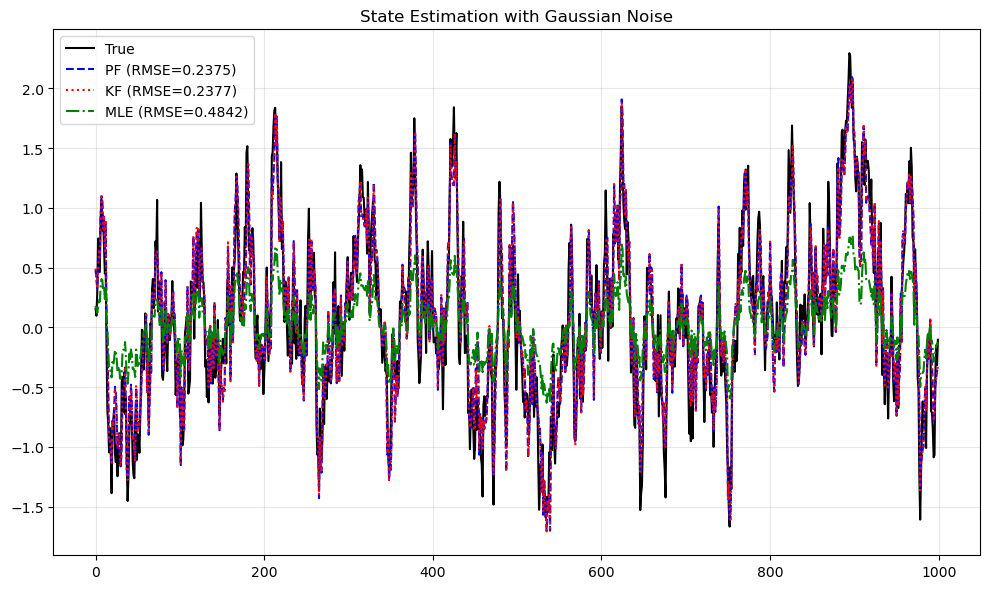


Noise type: t
PF RMSE: 0.3681
KF RMSE: 0.3624
MLE RMSE: 0.5806
RMSE Ratio (KF/PF): 0.9846

Particle Filter Parameter Estimates:
phi: True=0.9000, Est=0.8785, Error=-0.0215, %Error=2.39%
alpha: True=1.5000, Est=1.7178, Error=0.2178, %Error=14.52%
sigma2: True=0.1000, Est=0.1956, Error=0.0956, %Error=95.59%
tau2: True=0.2000, Est=0.2176, Error=0.0176, %Error=8.79%

Kalman Filter Parameter Estimates:
phi: True=0.9000, Est=0.8665, Error=-0.0335, %Error=3.72%
alpha: True=1.5000, Est=1.7031, Error=0.2031, %Error=13.54%
sigma2: True=0.1000, Est=0.2228, Error=0.1228, %Error=122.81%
tau2: True=0.2000, Est=0.1533, Error=-0.0467, %Error=23.35%

MLE Parameter Estimates:
phi: True=0.9000, Est=0.8779, Error=-0.0221, %Error=2.46%
alpha: True=1.5000, Est=2.9405, Error=1.4405, %Error=96.03%
sigma2: True=0.1000, Est=0.0576, Error=-0.0424, %Error=42.44%
tau2: True=0.2000, Est=0.5607, Error=0.3607, %Error=180.35%


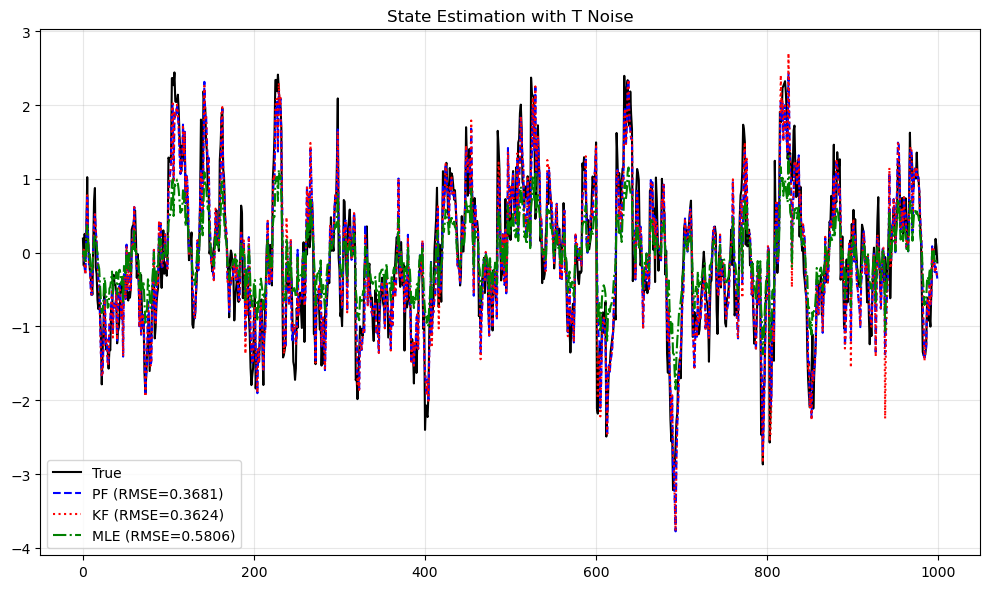


Comparison across noise types:
Noise Type  PF RMSE  KF RMSE  MLE RMSE  KF/PF Ratio  PF phi Error (%)  KF phi Error (%)  MLE phi Error (%)
  gaussian 0.237541 0.237710  0.484150     1.000712          0.163136          0.191234           0.112168
         t 0.368069 0.362388  0.580592     0.984565          2.386098          3.724267           2.455520


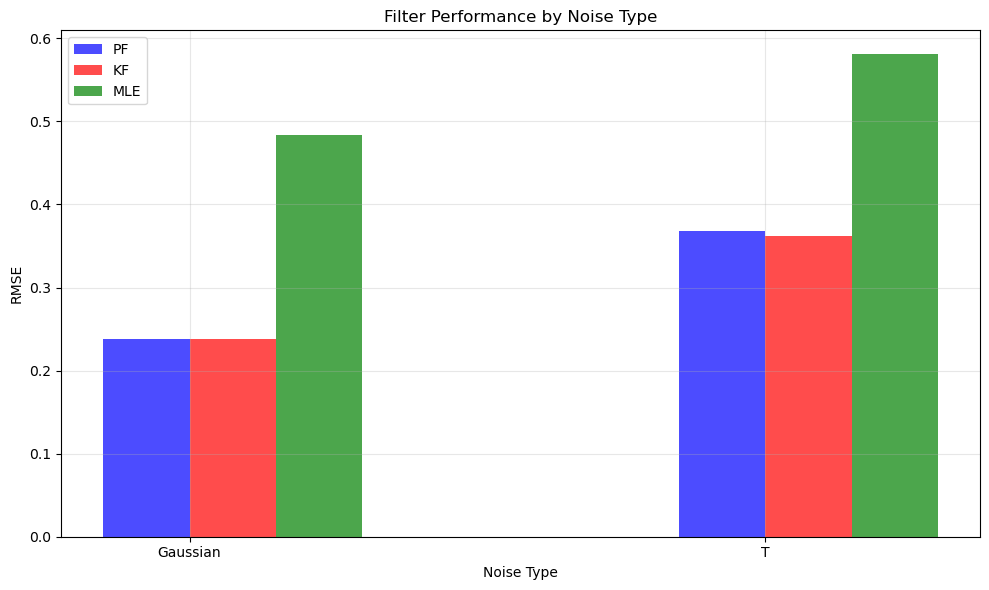

In [21]:

# Run tests with different noise types
gaussian_results = test_non_gaussian_noise('gaussian')
t_results = test_non_gaussian_noise('t')

# Compare results across noise types
noise_types = ['gaussian', 't']
results = [gaussian_results, t_results]

# Create comparison table
data = []
for res in results:
   data.append({
       'Noise Type': res['noise_type'],
       'PF RMSE': res['pf_rmse'],
       'KF RMSE': res['kf_rmse'],
       'MLE RMSE': res['mle_rmse'],
       'KF/PF Ratio': res['kf_rmse'] / res['pf_rmse'],
       'PF phi Error (%)': 100 * abs(res['pf_params']['phi'] - res['true_params']['phi']) / res['true_params']['phi'],
       'KF phi Error (%)': 100 * abs(res['kf_params']['phi'] - res['true_params']['phi']) / res['true_params']['phi'],
       'MLE phi Error (%)': 100 * abs(res['mle_params']['phi'] - res['true_params']['phi']) / res['true_params']['phi']
   })

comparison_df = pd.DataFrame(data)
print("\nComparison across noise types:")
print(comparison_df.to_string(index=False))

# Plot comparison bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.15
x = np.arange(len(noise_types))

plt.bar(x - bar_width/2, comparison_df['PF RMSE'], width=bar_width, label='PF', color='blue', alpha=0.7)
plt.bar(x + bar_width/2, comparison_df['KF RMSE'], width=bar_width, label='KF', color='red', alpha=0.7)
plt.bar(x + 3*bar_width/2, comparison_df['MLE RMSE'], width=bar_width, label='MLE', color='green', alpha=0.7)

plt.xlabel('Noise Type')
plt.ylabel('RMSE')
plt.title('Filter Performance by Noise Type')
plt.xticks(x, [n.capitalize() for n in noise_types])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Observations:
1. The most naive implementation, using a MLE estimator for our parameters clearly is the worst at capturing the essence of the underlying model both in terms of RMSE or Parameter Error.
2. Both the kalman filter and noise particle filtering perform very similarly both for Gauss an Noise and T distributed noise in terms of RMSE. But if we look at the parameter estimation in the gaussian noise we have similar performance but for non Gaussian (T-distributed) we observe a significant improvement in terms of parameter estimation


Particle Filter Parameter Estimates:


$\phi$: True=0.9000, Est=0.8785, Error=-0.0215, %Error=2.39%

$\alpha$: True=1.5000, Est=1.7178, Error=0.2178, %Error=14.52%

$\sigma^2$: True=0.1000, Est=0.1956, Error=0.0956, %Error=95.59%

$\tau^2$: True=0.2000, Est=0.2176, Error=0.0176, %Error=8.79%


Kalman Filter Parameter Estimates:


$\phi$: True=0.9000, Est=0.8665, Error=-0.0335, %Error=3.72%

$\alpha$: True=1.5000, Est=1.7031, Error=0.2031, %Error=13.54%

$\sigma^2$: True=0.1000, Est=0.2228, Error=0.1228, %Error=122.81%

$\tau^2$: True=0.2000, Est=0.1533, Error=-0.0467, %Error=23.35%



## Real data estimation of GDP gap:

We don't perform MLE estimate since it will just clutter our plot and will clearly not capture the nature of the time series as discussed before.

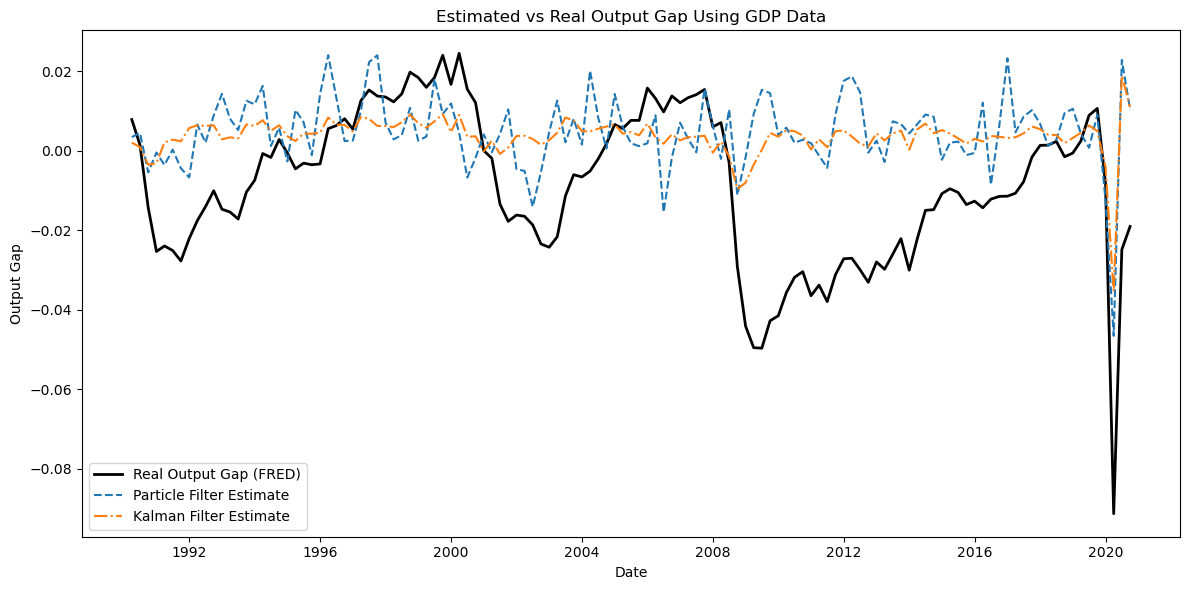

In [22]:
start = datetime(1990, 1, 1)
end   = datetime(2020, 12, 31)

# Download Real GDP (GDPC1) and Potential GDP (GDPPOT) series
gdpc1  = web.DataReader('GDPC1', 'fred', start, end)
gdppot = web.DataReader('GDPPOT', 'fred', start, end)

# Merge and compute the real output gap (as percentage deviation)
df = pd.concat([gdpc1.rename(columns={'GDPC1':'RealGDP'}),
                gdppot.rename(columns={'GDPPOT':'PotentialGDP'})], axis=1).dropna()
df['OutputGap'] = (df['RealGDP'] - df['PotentialGDP']) / df['PotentialGDP']

# Compute GDP growth (log differences)
df['GDP_Growth'] = np.log(df['RealGDP']).diff()
df = df.dropna()

y_real      = df['GDP_Growth'].values
nx          = len(y_real)
x_true_real = df['OutputGap'].values

# ## Estimate Latent Output Gap using Particle Filter and Kalman Filter
x_pf_real,_ = particle_filter(y_real,
                              phi=phi_true,
                              alpha=alpha_true,
                              sigma2=sigma2_true,
                              tau2=tau2_true,
                              N=1000)
x_kf_real, p_kf_est = kalman_filter(y_real,
                              phi=phi_true,
                              alpha=alpha_true,
                              sigma2=sigma2_true,
                              tau2=tau2_true)


plt.figure(figsize=(12, 6))
plt.plot(df.index, x_true_real, label='Real Output Gap (FRED)', color='black', linewidth=2)
plt.plot(df.index, x_pf_real,   label='Particle Filter Estimate', linestyle='--')
plt.plot(df.index, x_kf_real,   label='Kalman Filter Estimate', linestyle='-.')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Output Gap')
plt.title('Estimated vs Real Output Gap Using GDP Data')
plt.tight_layout()
plt.show()

### Results

The plot shows the estimated vs real output gap (GDP data, early 1990s – 2020):

- **Real Output Gap (FRED)**: solid black line  
- **Particle Filter Estimate**: blue dashed line  
- **Kalman Filter Estimate**: orange dash-dot line  

You can see major swings during the 2008 financial crisis and the 2020 COVID downturn. Both filters follow the overall trend, but the particle filter is noticeably jumpier.

### Findings

1. **Smoothness vs Sensitivity**  
   - Kalman filter is smoother, aligning with long-term trends.  
   - Particle filter reacts more strongly to short-term shocks.

2. **Crisis Response**  
   - During big shocks (2008, COVID), the real gap diverges from both estimates.  
   - Particle filter deviates fastest and most sharply.

3. **Recovery Dynamics**  
   - After shocks, both filters realign with the real gap.  
   - Kalman filter transitions back more gradually.

### Discussion

This comparison highlights the trade-off between methods: Kalman’s smoothness is ideal for long-run analysis, whereas the particle filter’s sensitivity can capture rapid shifts (at the risk of overreacting to noise). A good next step would be to compute the RMSE of each estimate against the real output gap to quantify which one tracks more accurately.

